In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class SocialAgent(Agent):
    def __init__(self, unique_id, model, initial_wealth, norm): # Norm = 0  or 1 corresponding to selfish or altruistic behavior
        super().__init__(unique_id, model)
        self.norm = norm
        self.wealth = initial_wealth
        self.employed = random.random() < self.model.employment_rate  # 80% chance of being employed initially

  

    def step(self):
        self.generate_wealth()
        self.expenditure()
        self.trade()
        self.redistribute_wealth()
        self.social_influence()



    def generate_wealth(self):
        # Proportional wealth increase.
        self.wealth *= 1 + self.model.growth_rate

        # Compute the salary based on the percentage of wealth
        proportional_salary = self.model.salary * self.wealth 

        # Fixed wealth increase which emulates a salary from a job. # This should depend on employment status.
        self.wealth += proportional_salary #self.model.salary

    def generate_wealth(self):
        self.wealth *= 1 + self.model.growth_rate
        if self.employed:
            proportional_salary = self.model.salary * self.wealth 
            self.wealth += proportional_salary
        
        if not self.employed:
            if self.random.random() < self.model.job_search_probability:
                self.employed = True
        elif self.random.random() < self.model.layoff_probability:
                self.employed = False


    def expenditure(self):
        
        random_expenditure = self.random.uniform(self.model.min_expenditure, self.model.max_expenditure)

        if self.wealth >=0:

            self.wealth -= random_expenditure 
    


    def trade(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        if self.wealth > 0:
            neighbor = self.random.choice(neighbors)
            trade_amount = self.model.trade_ratio * self.wealth
            self.wealth -= trade_amount
            neighbor.wealth += trade_amount

    def check_sufficiency(self):
        # If wealth is below sufficiency threshold, change to selfish
        if self.wealth < self.model.sufficiency_threshold:
            self.norm = 0 # selfish

    def redistribute_wealth(self):

        # Collect donations from altruistic agents
        if self.norm == 1 and self.wealth > 0:
            donation = self.model.donation_ratio * self.wealth
            self.wealth -= donation
            self.model.donation_pool += donation

        
        # Calculate the total amount needed by all agents below the sufficiency threshold
        total_needed = 0
        agents_below_threshold = []
        for agent in self.model.schedule.agents:
            if agent.wealth < self.model.sufficiency_threshold:
                needed = self.model.sufficiency_threshold - agent.wealth
                total_needed += needed
                agents_below_threshold.append((agent, needed))

        # Distribute the donation pool proportionally to all agents below the sufficiency threshold
        if total_needed > 0:
            for agent, needed in agents_below_threshold:
                proportion = needed / total_needed
                donation = proportion * self.model.donation_pool
                agent.wealth += donation

                # Update the norm of the agent if the agent is selfish
                if agent.norm == 0:
                    if random.random() < self.model.norm_change_probability:
                        agent.norm = 1

            # Reset the donation pool after redistribution
            self.model.donation_pool = 0
        ############################    


    def wealth_transfer(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        # Pick a random neighbor
        neighbor = self.random.choice(neighbors)

        # Check if norm of the agent is altruistic
        if self.norm == 1:
            # Only donate if the neighbor is poorer than the agent.
            if neighbor.wealth < self.wealth and self.wealth > 0:

                # Wealth transfer between agents based on trade ratio.
                wealth_transfer = self.model.donation_ratio * self.wealth
                self.wealth -= wealth_transfer
                neighbor.wealth += wealth_transfer

                # Update behaviour of the neighbor if neighbor is selfish
                if neighbor.norm == 0: # Tit for tat
                    if random.random() < self.model.norm_change_probability:
                        neighbor.norm = 1
    
    def social_influence(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        norm_counts = {0: 0, 1: 0}
        for neighbor in neighbors:
            norm_counts[neighbor.norm] += 1
        
        majority_norm = max(norm_counts, key=norm_counts.get)
        
        if norm_counts[majority_norm] > len(neighbors) / 2:
            # Check if the probability of norm_change
            # Print the norm_counts and len of neighbours
            # print(norm_counts[majority_norm], len(neighbors))

            if random.random() < self.model.norm_change_probability:
                self.norm = majority_norm


    
    def handle_negative_wealth(self):
        
        if self.wealth <= 0:
                self.wealth = 0.01

            


class SocialNormModel(Model):
    def __init__(
            self, 
            num_agents, 
            avg_node_degree, 
            rewiring_prob, 
            initial_wealth, 
            growth_rate, 
            trade_ratio, 
            salary, 

            max_expenditure,
            min_expenditure, 
            donation_ratio, 
            ratio_of_altruistic_agents,
            sufficiency_threshold,
            wealth_distribution="equal",
            employment_rate=0.8,
            job_search_probability=0.05,
            layoff_probability=0.02,
            norm_change_probability=0.60,
            

                 ):
        
        self.num_agents = num_agents
        self.growth_rate = growth_rate
        self.trade_ratio = trade_ratio
        self.salary = salary
        self.max_expenditure = max_expenditure
        self.min_expenditure = min_expenditure
        self.donation_ratio = donation_ratio
        self.wealth_distribution = wealth_distribution
        self.sufficiency_threshold = sufficiency_threshold
        self.employment_rate = employment_rate
        self.job_search_probability = job_search_probability
        self.layoff_probability = layoff_probability
        self.norm_change_probability = norm_change_probability
        self.donation_pool = 0

        # Create network

        #self.G = nx.gnp_random_graph(n=num_agents, p=rewiring_prob) # avg_node_degree
        # self.G = nx.watts_strogatz_graph(n=num_agents, k=avg_node_degree, p=rewiring_prob)

        # Barbasi-Albert
        self.G = nx.barabasi_albert_graph(n=num_agents, m=avg_node_degree)
        # try a different network that simulates an economic network
        # self.G = nx.erdos_renyi_graph(n=num_agents, p=0.1)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)

        # Generate initial wealth distribution
        initial_wealths = self.generate_initial_wealth(initial_wealth)

        # Shuffle the initial_wealths list
        random.shuffle(initial_wealths)

        # # Print initial wealth
        # print(initial_wealths)

        # Create agents
        for i, node in enumerate(self.G.nodes()):
            # Determine if the agent is altruistic based on the given ratio
            if random.random() < ratio_of_altruistic_agents:
                norm = 1
            else:
                norm = 0

            agent = SocialAgent(unique_id=i, model=self, initial_wealth=initial_wealths[i], norm=norm)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        # Data collector (optional)
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini, "donation_pool": "donation_pool"},
            agent_reporters={"Wealth": "wealth", "Norm": "norm"}

        )

    def generate_initial_wealth(self, initial_wealth):
        # Equal distribution
        if self.wealth_distribution == "equal":
            return [initial_wealth] * self.num_agents

        # Unequal distribution
        elif self.wealth_distribution == "unequal":
            return sorted([random.expovariate(1) * initial_wealth for _ in range(self.num_agents)], reverse=True)

        # Very Unequal distribution
        elif self.wealth_distribution == "very_unequal":
            return sorted([random.paretovariate(1.5) * initial_wealth for _ in range(self.num_agents)], reverse=True)
        
        # Normal distribution
        elif self.wealth_distribution == "normal": 
            return [random.normalvariate(0, 1) * initial_wealth for _ in range(self.num_agents)]

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def run_model(self, n):
        for _ in range(n):
            self.step()



/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_66238/2573374864.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


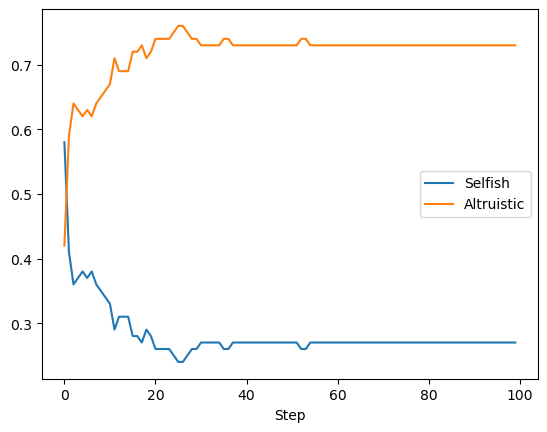

In [3]:
seed = 420
random.seed(seed)
np.random.seed(seed)

# Normal Single Run 

model = SocialNormModel(
            num_agents = 100, 
            avg_node_degree=1, 
            rewiring_prob=0.05, 
            initial_wealth = 150, 
            growth_rate = 0.01, #0.001, 
            trade_ratio = 0.05, #0.05, 
            salary = 0.1, #0.1, 
            max_expenditure = 15,
            min_expenditure=5,
            donation_ratio = 0.05, #not sensitive
            ratio_of_altruistic_agents=0.43,
            sufficiency_threshold = 6,
            wealth_distribution="unequal",
            norm_change_probability=0.74,
    
)

# Run the model
timesteps = 100
model.run_model(timesteps)

# Get the data
data = model.datacollector.get_agent_vars_dataframe()

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()

# Change legend labels 
plt.legend(["Selfish", "Altruistic"])
plt.show()




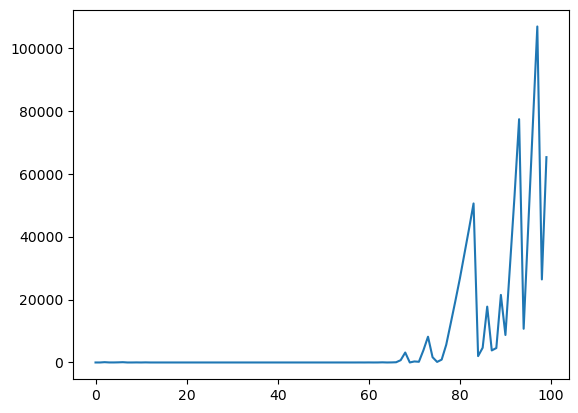

In [33]:
# Plot the donation pool over time
donation_pool = model.datacollector.get_model_vars_dataframe()["donation_pool"]
donation_pool.plot()

plt.show()

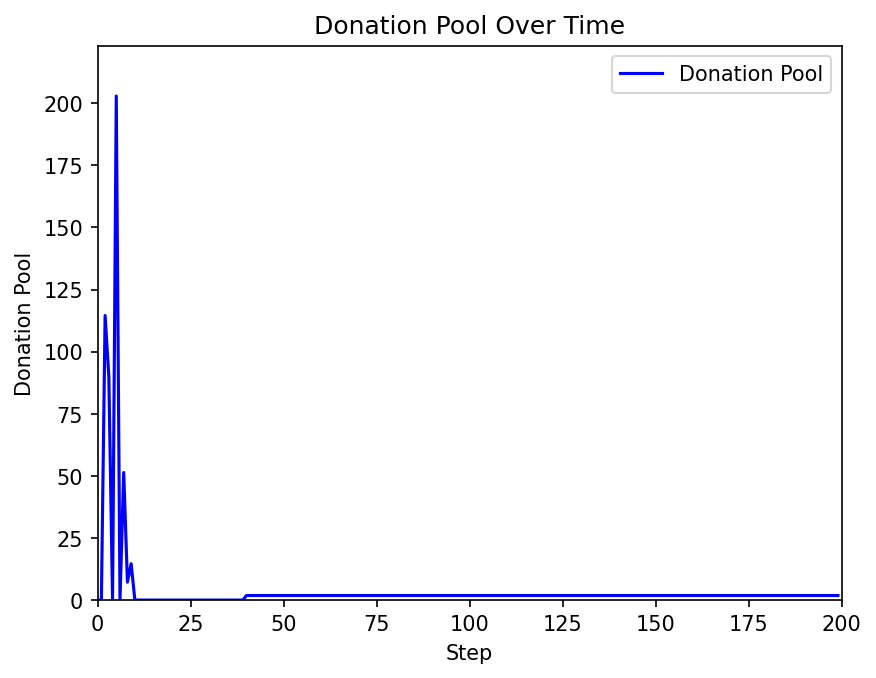

In [30]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Assuming model.datacollector.get_model_vars_dataframe() gives the required data
# Replace this line with the actual data collection from your model
donation_pool = model.datacollector.get_model_vars_dataframe()["donation_pool"]

# Function to update plot
def update_donation_pool_plot(i):
    ax.clear()
    ax.plot(donation_pool.index[:i+1], donation_pool[:i+1], label='Donation Pool', color='blue')
    ax.set_xlim(0, len(donation_pool))
    ax.set_ylim(0, donation_pool.max() * 1.1)  # Add some space above the max value for better visualization
    ax.set_xlabel('Step')
    ax.set_ylabel('Donation Pool')
    ax.set_title('Donation Pool Over Time')
    ax.legend(loc='upper right')

# Create a figure and axis for the plot
fig, ax = plt.subplots(dpi=150)

# Create the animation
fps = 10  # Frames per second
ani = animation.FuncAnimation(fig, update_donation_pool_plot, frames=len(donation_pool), interval=1000/fps)

# Save the animation as a gif
ani.save('donation_pool_time_series.gif', writer='pillow', fps=fps)

# Display the final plot
plt.show()


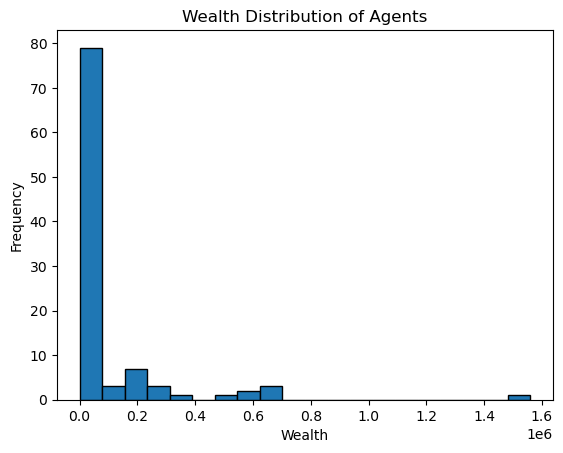

In [34]:
# Function to plot wealth distribution
def plot_wealth_distribution(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    
    plt.hist(agent_wealths, bins=20, edgecolor='k')
    plt.title('Wealth Distribution of Agents')
    plt.xlabel('Wealth')
    plt.ylabel('Frequency')
    plt.show()

plot_wealth_distribution(model)


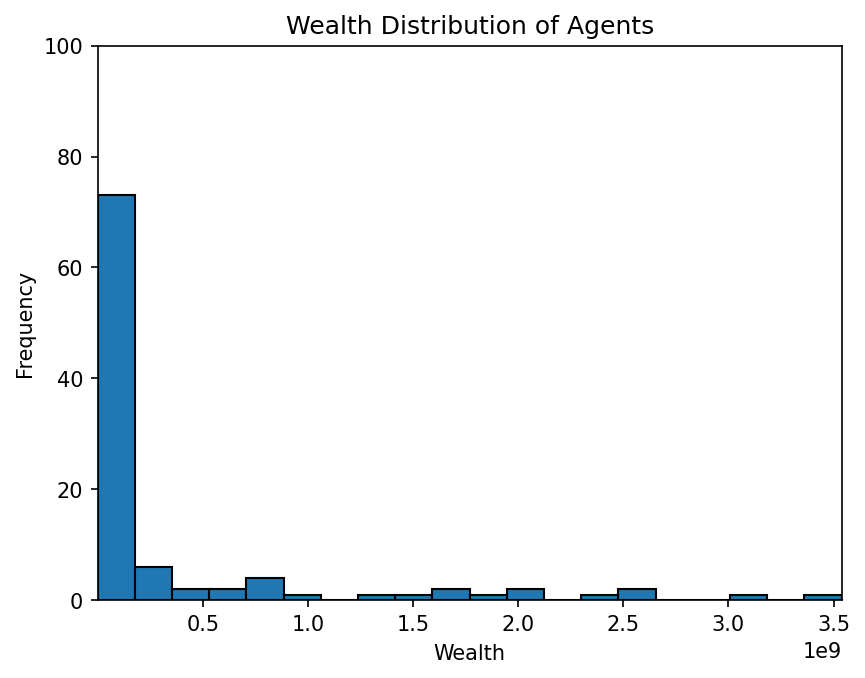

In [35]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

def extract_wealth_distribution(model):
    """Extracts wealth distribution from the model."""
    return [agent.wealth for agent in model.schedule.agents]

def update_wealth_distribution(i):
    ax.clear()
    agent_wealths = wealth_data_over_time[i]  # Get wealth data for step i
    ax.hist(agent_wealths, bins=20, edgecolor='k')
    ax.set_title('Wealth Distribution of Agents')
    ax.set_xlabel('Wealth')
    ax.set_ylabel('Frequency')
    ax.set_xlim(wealth_min, wealth_max)  # Set appropriate x limits
    ax.set_ylim(0, max_count)            # Set appropriate y limits

# Collect wealth distribution data over time
wealth_data_over_time = []
steps = 100  # Total number of steps, replace with the actual number of steps in your model

for step in range(steps):
    wealth_data_over_time.append(extract_wealth_distribution(model))
    model.step()  # Move model to the next step (assuming your model has a step() method)

# Determine the x and y limits for the plot
wealth_min = min(min(wealths) for wealths in wealth_data_over_time)
wealth_max = max(max(wealths) for wealths in wealth_data_over_time)
max_count = max(len(wealths) for wealths in wealth_data_over_time)

# Create a figure and axis for the plot
fig, ax = plt.subplots(dpi=150)

# Create the animation
fps = 10  # Frames per second
ani = animation.FuncAnimation(fig, update_wealth_distribution, frames=steps, interval=1000/fps)

# Save the animation as a gif
ani.save('wealth_distribution.gif', writer='pillow', fps=fps)

# Display the final plot
plt.show()



In [37]:
# Function to print the number of agents remaining
def print_number_of_agents(model):
    num_agents = len(model.schedule.agents)
    print(f'Number of agents remaining: {num_agents}')

print_number_of_agents(model)

Number of agents remaining: 100


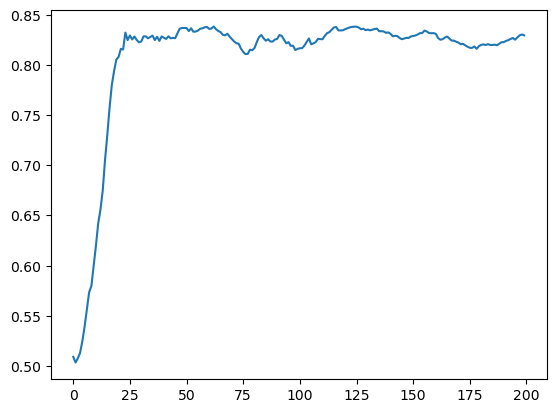

In [36]:
# Plot the Gini coefficient
gini = model.datacollector.get_model_vars_dataframe()["Gini"]

plt.plot(gini)

In [4]:
# Visualize the network
nx.draw(model.G, node_size=20)
plt.show()


### Equal

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_54864/2179026595.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


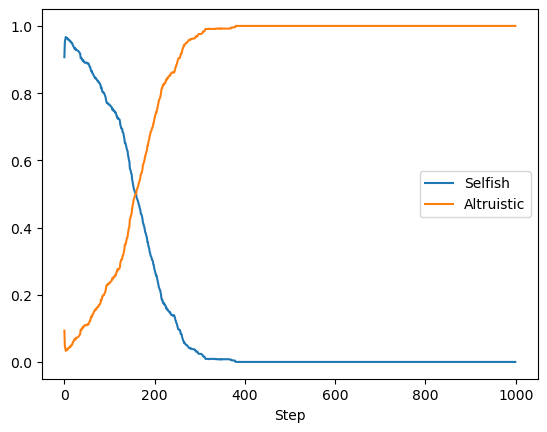

In [3]:


# Example usage
params = {
    "num_agents": 1000, # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.05,
    "initial_wealth": 100, # Can be heterogenous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 0.1, #10, # This can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "ratio_of_altruistic_agents": 0.10, # Main thing that we change #0.152 to 0.153
    "sufficiency_threshold": 6,
    "wealth_distribution": "equal"
}

timesteps = 1000
model = SocialNormModel(**params)
model.run_model(timesteps)

# # Data collection results
data = model.datacollector.get_agent_vars_dataframe()
# print(data)

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()
# Change legend labels 
plt.legend(["Selfish", "Altruistic"])
plt.show()

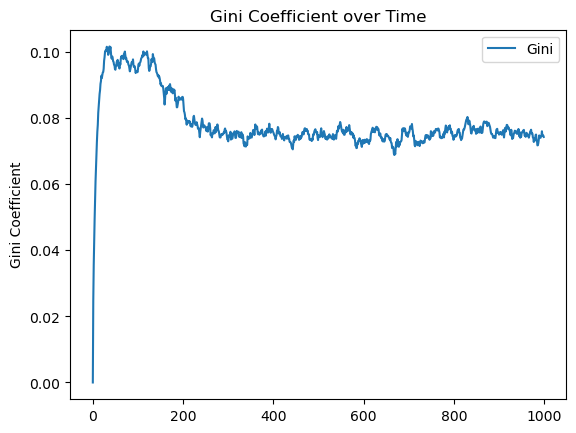

In [4]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [5]:
# Get the wealth of all the agents for all the timesteps
wealth = model.datacollector.get_agent_vars_dataframe()

# Check if wealth is negative
print(wealth[wealth["Wealth"] < 0])





Empty DataFrame
Columns: [Wealth, Norm]
Index: []


## Batch run

In [1]:
from mesa.batchrunner import batch_run
import pandas as pd


# Define the static parameters
params = {
    "num_agents": 100,  # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.05,
    "initial_wealth": 100,  # Can be heterogeneous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 0.1,  # Can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "wealth_distribution": "equal"
}

# Define the varying parameters
ratio_of_altruistic_agents_values = [0.05, 0.10, 0.15]  # Values to vary

timesteps = 1000
iterations = 10

# Placeholder for storing batch results
all_results = []

# Loop through each value of varying parameter ratio_of_altruistic_agents
for ratio in ratio_of_altruistic_agents_values:
    for iteration in range(iterations):
        # Update the params with the current value of ratio_of_altruistic_agents
        params["ratio_of_altruistic_agents"] = ratio

        # Instantiate and run the model
        model = SocialNormModel(**params)
        model.run_model(timesteps)
        
        # Collect the data
        data = model.datacollector.get_agent_vars_dataframe()
        data["iteration"] = iteration
        data["ratio_of_altruistic_agents"] = ratio
        all_results.append(data)

# Concatenate all results
all_data = pd.concat(all_results)


NameError: name 'SocialNormModel' is not defined

##### Visualizing Batch Runs

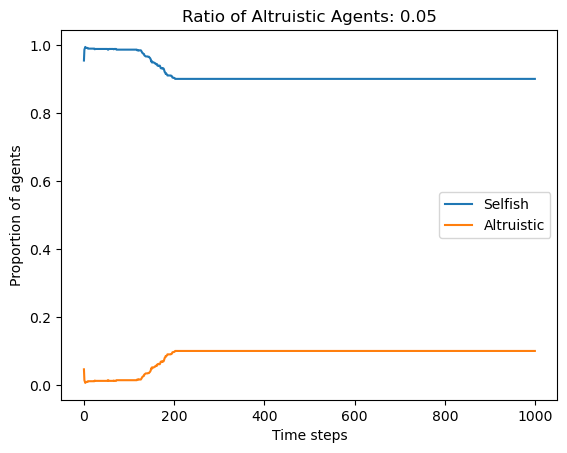

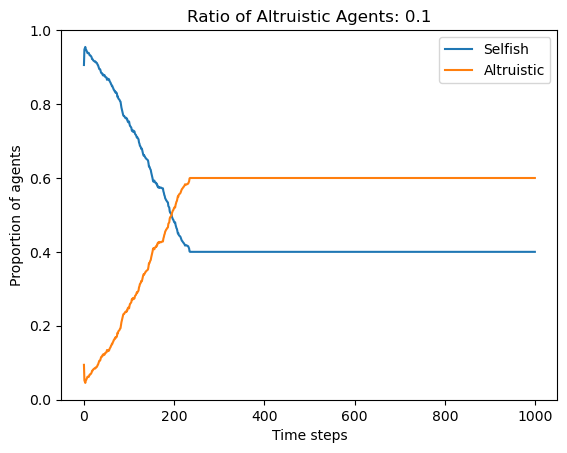

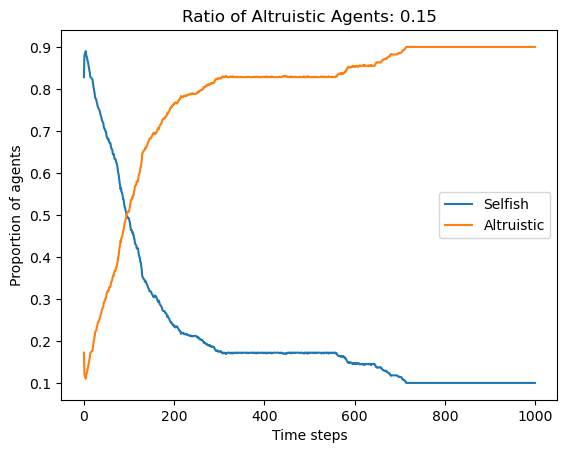

In [9]:
# Process and visualize results
for ratio in ratio_of_altruistic_agents_values:
    # Filter data for the current ratio
    ratio_data = all_data[all_data["ratio_of_altruistic_agents"] == ratio]

    # Calculate the norm counts as a proportion
    norm_counts = ratio_data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
    
    # Plot the percentage of altruistic agents over time
    norm_counts.plot(title=f"Ratio of Altruistic Agents: {ratio}")
    
    # Change legend labels
    plt.legend(["Selfish", "Altruistic"])
    plt.xlabel("Time steps")
    plt.ylabel("Proportion of agents")
    plt.show()

### Unequal

In [10]:
from mesa.batchrunner import batch_run
import pandas as pd


# Define the static parameters
params = {
    "num_agents": 100,  # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.05,
    "initial_wealth": 100,  # Can be heterogeneous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 0.1,  # Can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "wealth_distribution": "unequal"
}

# Define the varying parameters
ratio_of_altruistic_agents_values = [0.05, 0.10, 0.15]  # Values to vary

timesteps = 1000
iterations = 10

# Placeholder for storing batch results
all_results = []

# Loop through each value of varying parameter ratio_of_altruistic_agents
for ratio in ratio_of_altruistic_agents_values:
    for iteration in range(iterations):
        # Update the params with the current value of ratio_of_altruistic_agents
        params["ratio_of_altruistic_agents"] = ratio

        # Instantiate and run the model
        model = SocialNormModel(**params)
        model.run_model(timesteps)
        
        # Collect the data
        data = model.datacollector.get_agent_vars_dataframe()
        data["iteration"] = iteration
        data["ratio_of_altruistic_agents"] = ratio
        all_results.append(data)

# Concatenate all results
all_data = pd.concat(all_results)


/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In th

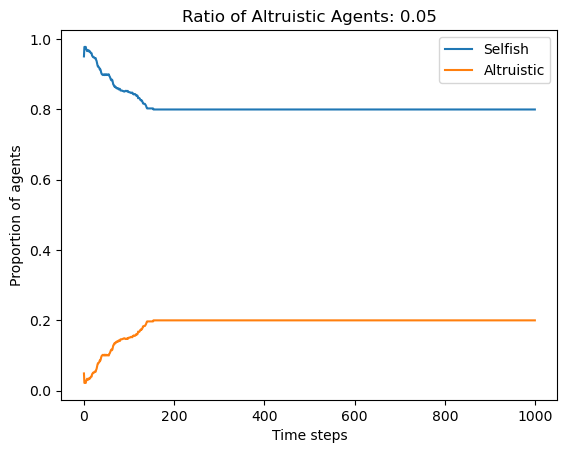

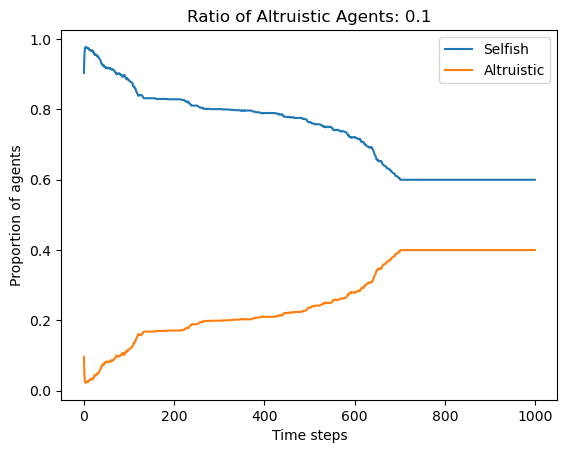

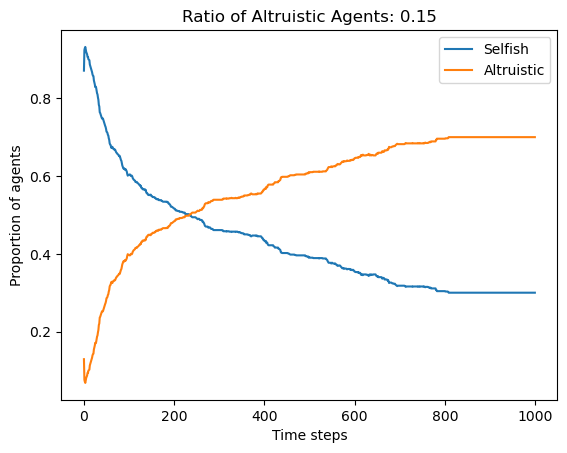

In [11]:
# Process and visualize results
for ratio in ratio_of_altruistic_agents_values:
    # Filter data for the current ratio
    ratio_data = all_data[all_data["ratio_of_altruistic_agents"] == ratio]

    # Calculate the norm counts as a proportion
    norm_counts = ratio_data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
    
    # Plot the percentage of altruistic agents over time
    norm_counts.plot(title=f"Ratio of Altruistic Agents: {ratio}")
    
    # Change legend labels
    plt.legend(["Selfish", "Altruistic"])
    plt.xlabel("Time steps")
    plt.ylabel("Proportion of agents")
    plt.show()

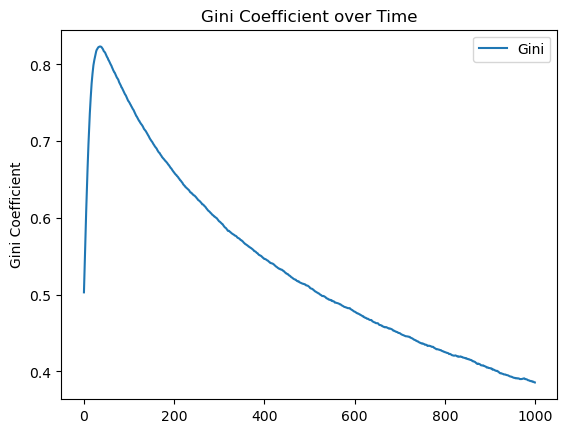

In [10]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

#### Very Unequal

In [14]:
from mesa.batchrunner import batch_run
import pandas as pd


# Define the static parameters
params = {
    "num_agents": 100,  # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.05,
    "initial_wealth": 100,  # Can be heterogeneous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 0.1,  # Can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "wealth_distribution": "very_unequal"
}

# Define the varying parameters
ratio_of_altruistic_agents_values = [0.05, 0.10, 0.15]  # Values to vary

timesteps = 10000
iterations = 10

# Placeholder for storing batch results
all_results = []

# Loop through each value of varying parameter ratio_of_altruistic_agents
for ratio in ratio_of_altruistic_agents_values:
    for iteration in range(iterations):
        # Update the params with the current value of ratio_of_altruistic_agents
        params["ratio_of_altruistic_agents"] = ratio

        # Instantiate and run the model
        model = SocialNormModel(**params)
        model.run_model(timesteps)
        
        # Collect the data
        data = model.datacollector.get_agent_vars_dataframe()
        data["iteration"] = iteration
        data["ratio_of_altruistic_agents"] = ratio
        all_results.append(data)

# Concatenate all results
all_data = pd.concat(all_results)


/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_33536/3161745108.py:11: FutureWarning: The Mesa Model class was not initialized. In th

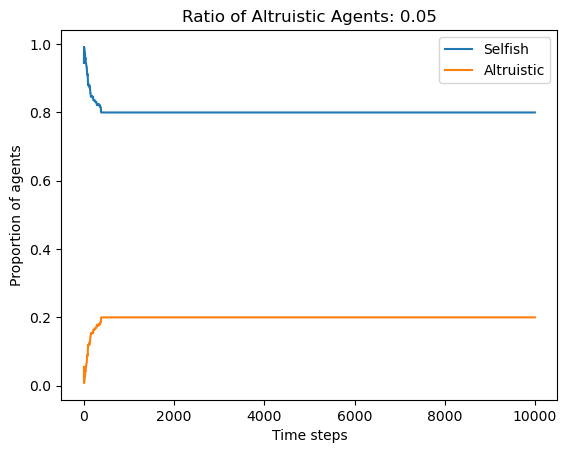

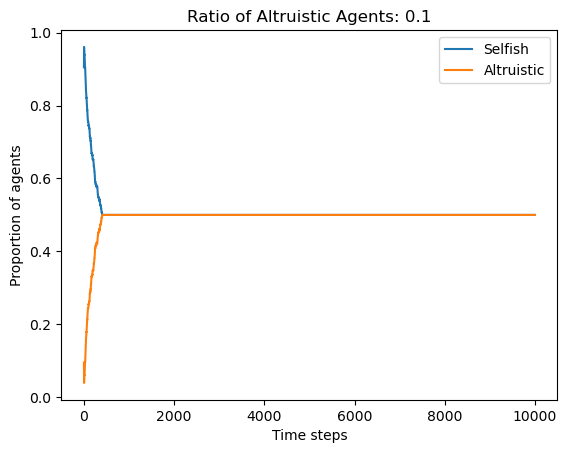

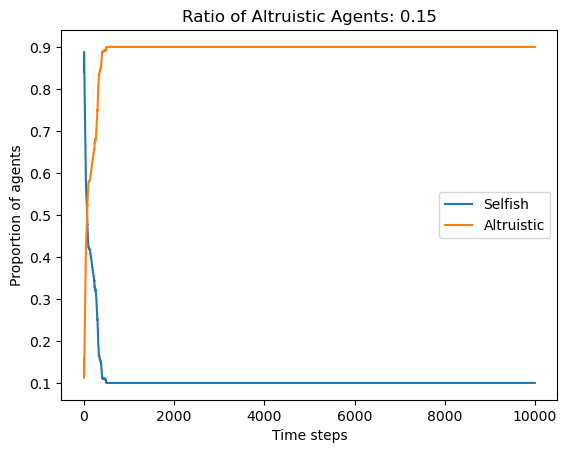

In [15]:
# Process and visualize results
for ratio in ratio_of_altruistic_agents_values:
    # Filter data for the current ratio
    ratio_data = all_data[all_data["ratio_of_altruistic_agents"] == ratio]

    # Calculate the norm counts as a proportion
    norm_counts = ratio_data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
    
    # Plot the percentage of altruistic agents over time
    norm_counts.plot(title=f"Ratio of Altruistic Agents: {ratio}")
    
    # Change legend labels
    plt.legend(["Selfish", "Altruistic"])
    plt.xlabel("Time steps")
    plt.ylabel("Proportion of agents")
    plt.show()

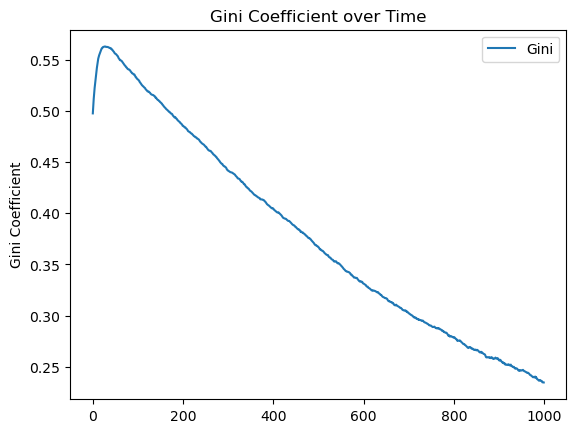

In [12]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

#### Normal

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_29757/860603407.py:31: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


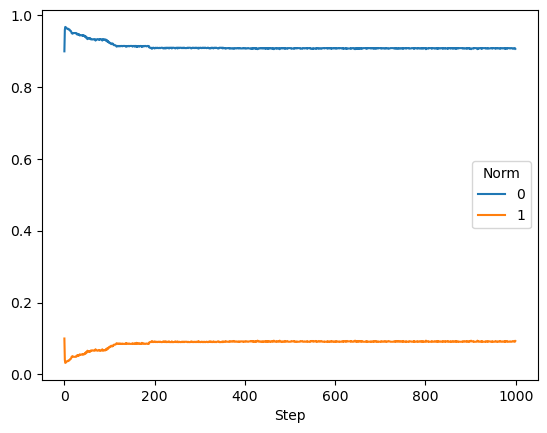

In [13]:


# Example usage
params = {
    "num_agents": 1000, # Can increase this
    "avg_node_degree": 4,
    "rewiring_prob": 0.05,
    "initial_wealth": 100, # Can be heterogenous
    "growth_rate": 0.01,
    "trade_ratio": 0.05,
    "salary": 0.1, #10, # This can vary
    "expenditure": 5,
    "donation_ratio": 0.01,
    "ratio_of_altruistic_agents": 0.10, # Main thing that we change #0.152 to 0.153
    "wealth_distribution": "normal"
}

timesteps = 1000
model = SocialNormModel(**params)
model.run_model(timesteps)

# # Data collection results
data = model.datacollector.get_agent_vars_dataframe()
# print(data)

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()
plt.show()

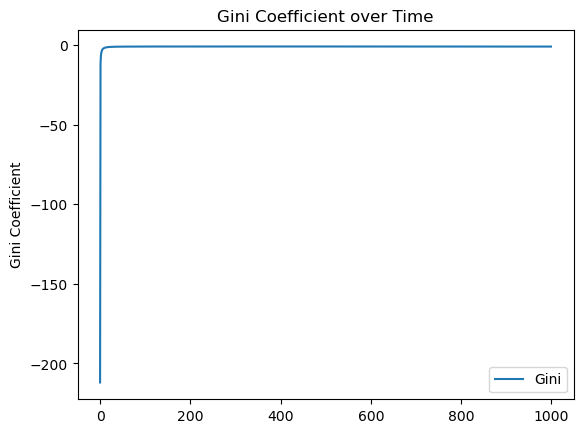

In [14]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [10]:
class SocialAgent(Agent):
    def __init__(self, unique_id, model, initial_wealth, norm): 
        super().__init__(unique_id, model)
        self.norm = norm
        self.wealth = initial_wealth
        self.health = 1.0  # Assume health is a value between 0 and 1
        self.employed = random.random() < 0.8  # 80% chance of being employed initially
        self.neighbors = []

    def step(self):
        self.generate_wealth()
        self.expenditure()
        self.trade()
        self.wealth_transfer()
        self.social_influence()
        self.kill_agents()
        self.update_health()

    def generate_wealth(self):
        self.wealth *= 1 + self.model.growth_rate
        if self.employed:
            proportional_salary = self.model.salary * self.wealth * self.health
            self.wealth += proportional_salary
        
        if not self.employed:
            if self.random.random() < self.model.job_search_probability:
                self.employed = True
        elif self.random.random() < self.model.layoff_probability:
                self.employed = False

    def expenditure(self):
        lifestyle_inflation_factor = self.model.lifestyle_inflation_factor
        random_expenditure = self.random.uniform(self.model.min_expenditure, self.model.max_expenditure)
        medical_cost = self.model.medical_cost_factor * (1 - self.health)
        self.wealth -= (random_expenditure + lifestyle_inflation_factor * self.wealth + medical_cost)

    def update_health(self):
        self.health -= self.model.health_decay_rate
        if self.health < self.model.health_threshold:
            self.health -= self.model.unhealthy_penalty

    def trade(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        if self.wealth > 0:
            neighbor = self.random.choice(neighbors)
            trade_amount = self.model.trade_ratio * self.wealth
            self.wealth -= trade_amount
            neighbor.wealth += trade_amount

    def check_sufficiency(self):
        if self.wealth < self.model.sufficiency_threshold:
            self.norm = 0  # selfish

    def wealth_transfer(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        neighbor = self.random.choice(neighbors)

        if self.norm == 1:
            if neighbor.wealth < self.wealth:
                wealth_transfer = self.model.donation_ratio * self.wealth
                self.wealth -= wealth_transfer
                neighbor.wealth += wealth_transfer

                if neighbor.norm == 0:  # Tit for tat
                    neighbor.norm = 1
    
    def social_influence(self):
        neighbors = self.model.grid.get_neighbors(self.pos)
        if not neighbors:
            return

        norm_counts = {0: 0, 1: 0}
        for neighbor in neighbors:
            norm_counts[neighbor.norm] += 1
        
        majority_norm = max(norm_counts, key=norm_counts.get)
        
        if norm_counts[majority_norm] > len(neighbors) / 2:
            self.norm = majority_norm

    def kill_agents(self):
        if self.wealth <= 0:
            self.model.schedule.remove(self)
            self.model.grid.remove_agent(self)

In [11]:
class SocialNormModel(Model):
    def __init__(self, num_agents, avg_node_degree, rewiring_prob, initial_wealth, growth_rate, trade_ratio, salary, expenditure, donation_ratio, ratio_of_altruistic_agents, sufficiency_threshold, wealth_distribution="equal", lifestyle_inflation_factor=0.1, min_expenditure=10, max_expenditure=20, tax_rate=0.1, medical_cost_factor=0.05, health_decay_rate=0.01, health_threshold=0.3, unhealthy_penalty=0.1, job_search_probability=0.05, layoff_probability=0.02):
        self.num_agents = num_agents
        self.growth_rate = growth_rate
        self.trade_ratio = trade_ratio
        self.salary = salary
        self.expenditure = expenditure
        self.donation_ratio = donation_ratio
        self.wealth_distribution = wealth_distribution
        self.sufficiency_threshold = sufficiency_threshold
        self.lifestyle_inflation_factor = lifestyle_inflation_factor
        self.min_expenditure = min_expenditure
        self.max_expenditure = max_expenditure
        self.tax_rate = tax_rate
        self.medical_cost_factor = medical_cost_factor
        self.health_decay_rate = health_decay_rate
        self.health_threshold = health_threshold
        self.unhealthy_penalty = unhealthy_penalty
        self.job_search_probability = job_search_probability
        self.layoff_probability = layoff_probability

        self.G = nx.barabasi_albert_graph(n=num_agents, m=avg_node_degree)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)

        initial_wealths = self.generate_initial_wealth(initial_wealth)
        random.shuffle(initial_wealths)

        for i, node in enumerate(self.G.nodes()):
            if random.random() < ratio_of_altruistic_agents:
                norm = 1
            else:
                norm = 0

            agent = SocialAgent(unique_id=i, model=self, initial_wealth=initial_wealths[i], norm=norm)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

        self.datacollector = DataCollector(
            # model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Norm": "norm", "Health": "health", "Employed": "employed"}
        )

    def generate_initial_wealth(self, initial_wealth):
        if self.wealth_distribution == "equal":
            return [initial_wealth] * self.num_agents
        elif self.wealth_distribution == "unequal":
            return sorted([random.expovariate(1) * initial_wealth for _ in range(self.num_agents)], reverse=True)
        elif self.wealth_distribution == "very_unequal":
            return sorted([random.paretovariate(1.5) * initial_wealth for _ in range(self.num_agents)], reverse=True)
        elif self.wealth_distribution == "normal": 
            return [random.normalvariate(initial_wealth, initial_wealth / 2) for _ in range(self.num_agents)]

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        # if self.schedule.time % 10 == 0:  # Or another suitable interval
        self.wealth_redistribution()

    def run_model(self, n):
        for _ in range(n):
            self.step()

    def wealth_redistribution(self):
        total_wealth = sum([agent.wealth for agent in self.schedule.agents])
        tax_rate = self.tax_rate
        redistribution_pool = total_wealth * tax_rate

        for agent in self.schedule.agents:
            agent.wealth -= tax_rate * agent.wealth

        welfare_distribution = redistribution_pool / self.num_agents

        for agent in self.schedule.agents:
            agent.wealth += welfare_distribution


/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_57629/4095831728.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


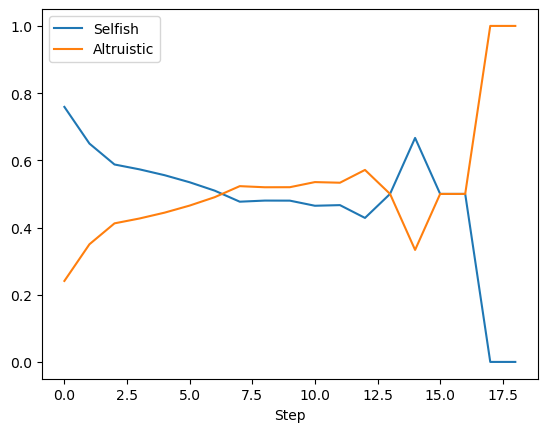

In [13]:
seed = 42
random.seed(seed)
np.random.seed(seed)

# Normal Single Run 

model = SocialNormModel(
            num_agents = 1000, 
            avg_node_degree=1, 
            rewiring_prob=0.05, 
            initial_wealth = 100, 
            growth_rate = 0.01, 
            trade_ratio = 0.05, 
            salary = 0.1, 
            expenditure = 8, 
            donation_ratio = 0.01, 
            ratio_of_altruistic_agents=0.25,
            sufficiency_threshold = 6,
            wealth_distribution="unequal",
            lifestyle_inflation_factor=0.1,
            min_expenditure=10,
            max_expenditure=20,
            tax_rate=0.1,
            medical_cost_factor=0.05,
            health_decay_rate=0.01,
            health_threshold=0.3,
            unhealthy_penalty=0.1,
            job_search_probability=0.05,
            layoff_probability=0.02
            
    
)

# Run the model
timesteps = 1000
model.run_model(timesteps)

# Get the data
data = model.datacollector.get_agent_vars_dataframe()

# Plot the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
norm_counts.plot()

# Change legend labels 
plt.legend(["Selfish", "Altruistic"])
plt.show()



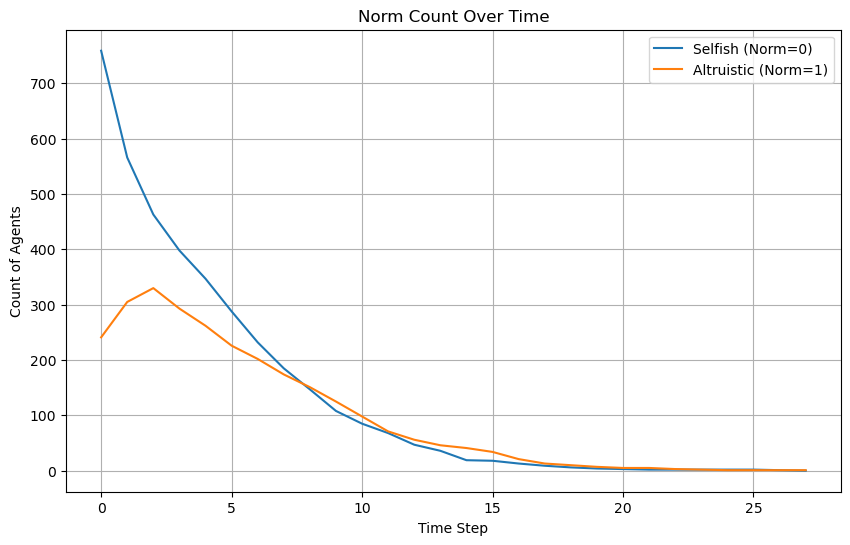

In [9]:
import matplotlib.pyplot as plt

# Extract agent data
data = model.datacollector.get_agent_vars_dataframe()

# Create a pivot table with norms count over time
norm_count = data.reset_index().groupby(['Step', 'Norm'])['Norm'].count().unstack().fillna(0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(norm_count.index, norm_count[0], label='Selfish (Norm=0)')
plt.plot(norm_count.index, norm_count[1], label='Altruistic (Norm=1)')

plt.xlabel('Time Step')
plt.ylabel('Count of Agents')
plt.title('Norm Count Over Time')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_61845/3573818691.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  norm_value = int(d[d['AgentID'] == node]['Norm'])


ValueError: 'top' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

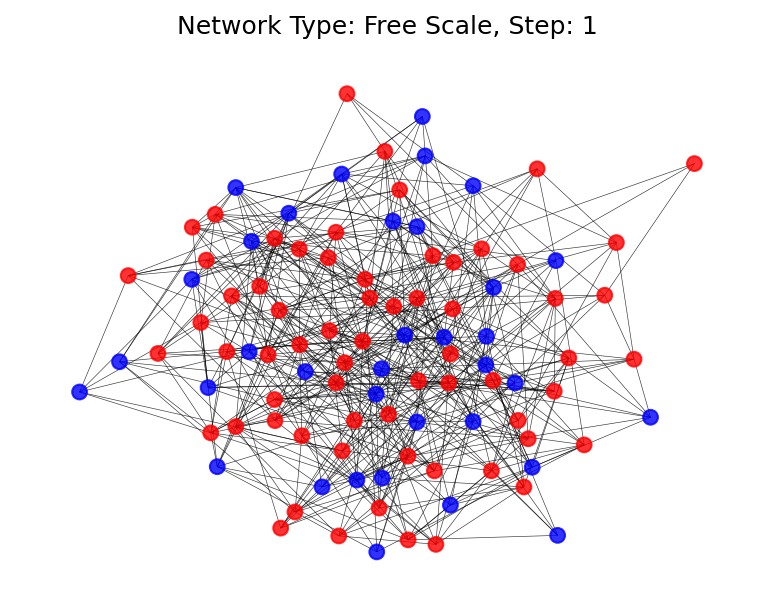

In [10]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd
import matplotlib.patches as mpatches

# Assuming the following variables are defined somewhere in your code
# model.G : The networkx graph
# data : The pandas DataFrame containing agent data

pos = nx.spring_layout(model.G)

def draw(i):
    networktype = 'Free Scale'
    stepnumber = i * 2
    d = data.reset_index()
    d = d[d['Step'] == stepnumber]
    
    for node in model.G.nodes:
        norm_value = int(d[d['AgentID'] == node]['Norm'])
        if norm_value == 0:
            model.G.nodes[node]['color'] = 'red'
        elif norm_value == 1:
            model.G.nodes[node]['color'] = 'blue'
    
    node_colors = [model.G.nodes[n]['color'] for n in model.G.nodes()]
    
    # Create legend patches
    selfish_patch = mpatches.Patch(color='red', label='Selfish')
    altruistic_patch = mpatches.Patch(color='blue', label='Altruistic')
    
    ax.cla()  # Clear the axis for fresh drawing
    ax.axis('off')  # Turn off the axis
    ax.set_title(f'Network Type: {networktype}, Step: {stepnumber + 1}')
    
    # Draw the network
    nx.draw(model.G, pos, node_color=node_colors, with_labels=False, node_size=50, width=0.3, alpha=0.8, ax=ax)
    
    # Add the legend
    ax.legend(handles=[selfish_patch, altruistic_patch], loc='right')

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()

draw(0)  # Draw the initial state

fps = 1  # Frames per second
ani = animation.FuncAnimation(fig, draw, frames=50, interval=1000/fps)
ani.save('change.gif', writer='pillow', fps=fps)
plt.show()

/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_63142/1700767444.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  norm_value = int(d[d['AgentID'] == node]['Norm'])
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_63142/1700767444.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  norm_value = int(d[d['AgentID'] == node]['Norm'])
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_63142/1700767444.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  norm_value = int(d[d['AgentID'] == node]['Norm'])
/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_63142/1700767444.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError 

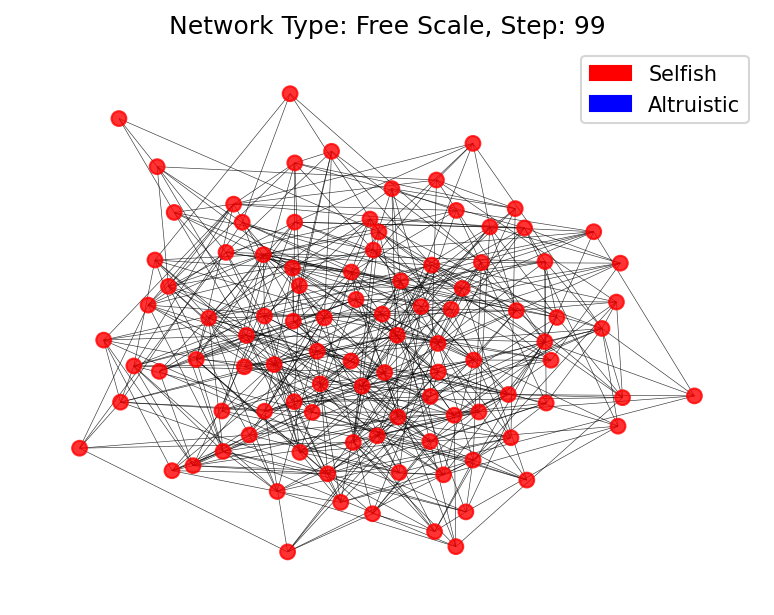

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd
import matplotlib.patches as mpatches

# Assuming the following variables are defined somewhere in your code
# model.G : The networkx graph
# data : The pandas DataFrame containing agent data

pos = nx.spring_layout(model.G)

def draw(i):
    networktype = 'Free Scale'
    stepnumber = i * 2
    d = data.reset_index()
    d = d[d['Step'] == stepnumber]
    
    for node in model.G.nodes:
        norm_value = int(d[d['AgentID'] == node]['Norm'])
        if norm_value == 0:
            model.G.nodes[node]['color'] = 'red'
        elif norm_value == 1:
            model.G.nodes[node]['color'] = 'blue'
    
    node_colors = [model.G.nodes[n]['color'] for n in model.G.nodes()]
    
    # Create legend patches
    selfish_patch = mpatches.Patch(color='red', label='Selfish')
    altruistic_patch = mpatches.Patch(color='blue', label='Altruistic')
    
    ax.cla()  # Clear the axis for fresh drawing
    ax.axis('off')  # Turn off the axis
    ax.set_title(f'Network Type: {networktype}, Step: {stepnumber + 1}')
    
    # Draw the network
    nx.draw(model.G, pos, node_color=node_colors, with_labels=False, node_size=50, width=0.3, alpha=0.8, ax=ax)
    
    # Add the legend, positioned in the top-right corner
    ax.legend(handles=[selfish_patch, altruistic_patch], loc='upper right')

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()

draw(0)  # Draw the initial state

fps = 1  # Frames per second
ani = animation.FuncAnimation(fig, draw, frames=50, interval=1000/fps)
ani.save('change.gif', writer='pillow', fps=fps)
plt.show()

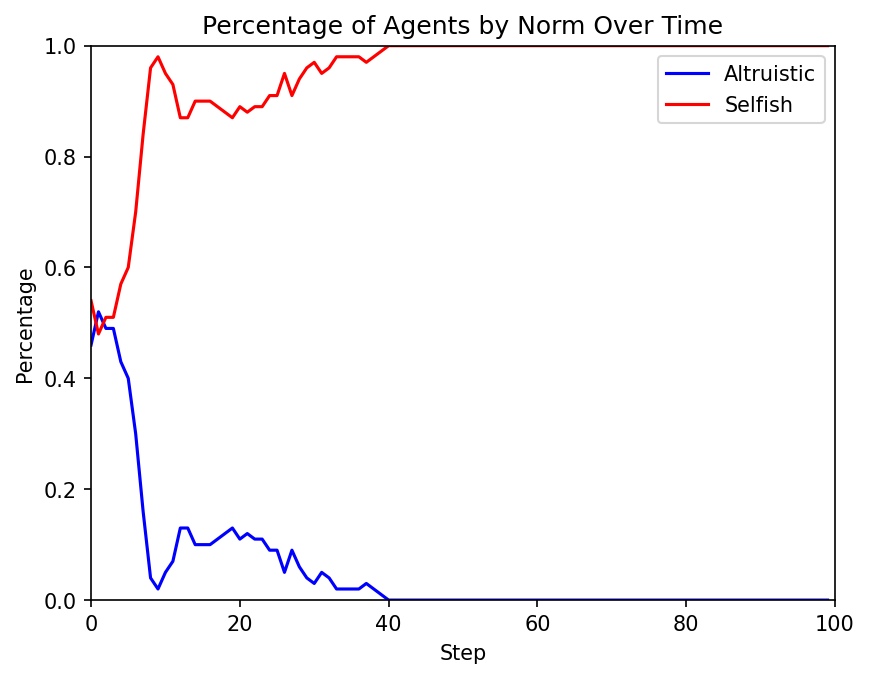

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Calculate the percentage of altruistic agents over time
norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)

# Function to update plot
def update_plot(i):
    ax.clear()
    ax.plot(norm_counts.index[:i+1], norm_counts[1][:i+1], label='Altruistic', color='blue')
    ax.plot(norm_counts.index[:i+1], norm_counts[0][:i+1], label='Selfish', color='red')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, timesteps)
    ax.set_xlabel('Step')
    ax.set_ylabel('Percentage')
    ax.set_title('Percentage of Agents by Norm Over Time')
    ax.legend(loc='upper right')

# Create a figure and axis for the plot
fig, ax = plt.subplots(dpi=150)

# Create the animation
fps = 10  # Frames per second
ani = animation.FuncAnimation(fig, update_plot, frames=timesteps, interval=1000/fps)

# Save the animation as a gif
ani.save('time_series.gif', writer='pillow', fps=fps)

# Display the final plot
plt.show()

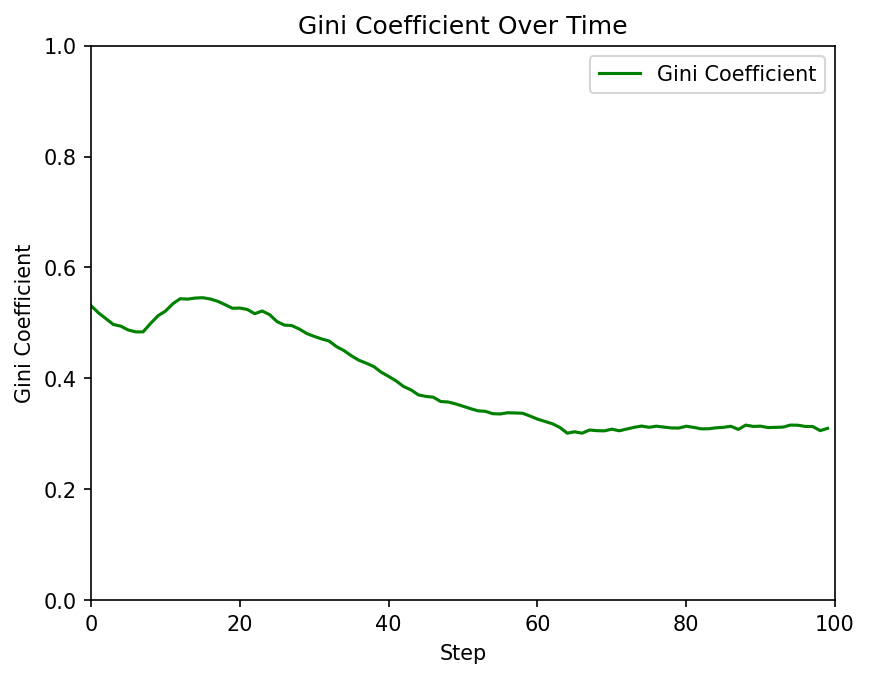

In [24]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Assuming model.datacollector.get_model_vars_dataframe() gives the required data
# For the purpose of this implementation, we will simulate some sample data

# Sample Gini coefficient data creation, replace this with your actual data

# Function to update plot
def update_gini_plot(i):
    ax.clear()
    ax.plot(gini.index[:i+1], gini[:i+1], label='Gini Coefficient', color='green')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, timesteps)
    ax.set_xlabel('Step')
    ax.set_ylabel('Gini Coefficient')
    ax.set_title('Gini Coefficient Over Time')
    ax.legend(loc='upper right')

# Create a figure and axis for the plot
fig, ax = plt.subplots(dpi=150)

# Create the animation
fps = 10  # Frames per second
ani = animation.FuncAnimation(fig, update_gini_plot, frames=timesteps, interval=1000/fps)

# Save the animation as a gif
ani.save('gini_time_series.gif', writer='pillow', fps=fps)

# Display the final plot
plt.show()

IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x12c787dc0> (for post_execute), with arguments args (),kwargs {}:


KeyError: 'Step'

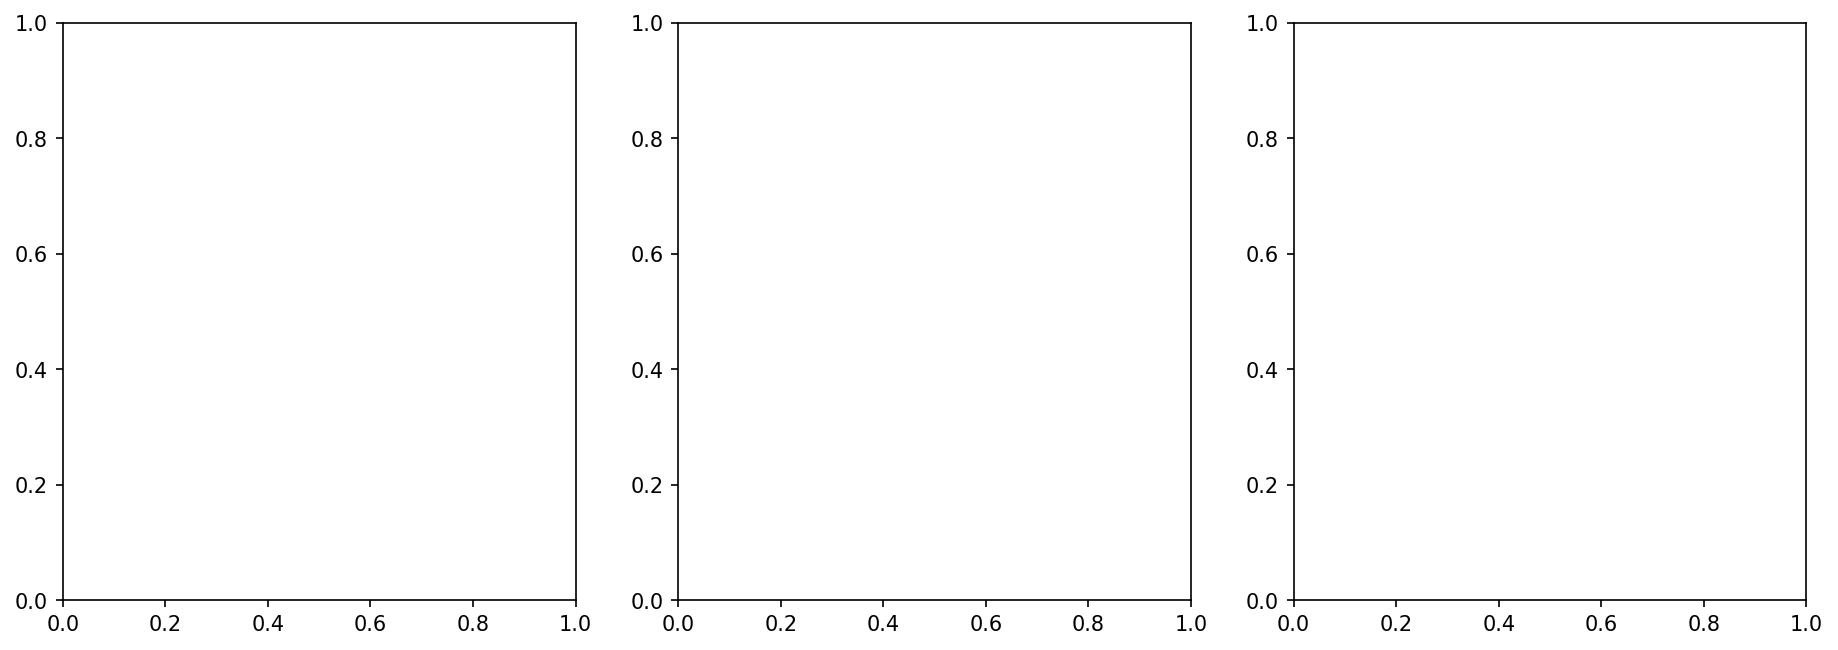

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd
import matplotlib.patches as mpatches

# Sample data simulation for demonstration purposes.
# Replace this with your actual data.


# Function to update all subplots
def update_all(i):
    stepnumber = i
    
    
    norm_counts = data.groupby("Step")["Norm"].value_counts(normalize=True).unstack().fillna(0)
    
    # Filter data for the current step
    current_step_data = data[data['Step'] == stepnumber].set_index('AgentID')
    
    for node in model.G.nodes():
        if node in current_step_data.index:
            norm_value = current_step_data.loc[node, 'Norm']
            model.G.nodes[node]['color'] = 'blue' if norm_value == 1 else 'red'
        else:
            model.G.nodes[node]['color'] = 'gray'  # Default color if there's no data for the node
    
    node_colors = [model.G.nodes[n]['color'] for n in model.G.nodes()]
    
    # Clear the axis and draw the graph
    ax1.cla()
    ax1.axis('off')
    ax1.set_title(f'Network: Step {stepnumber}')
    nx.draw(model.G, pos, node_color=node_colors, with_labels=False, node_size=50, width=0.3, alpha=0.8, ax=ax1)
    selfish_patch = mpatches.Patch(color='red', label='Selfish')
    altruistic_patch = mpatches.Patch(color='blue', label='Altruistic')
    ax1.legend(handles=[selfish_patch, altruistic_patch], loc='lower right')
    
    # Update Norm Percentage Plot
    ax2.cla()
    ax2.plot(norm_counts.index[:i+1], norm_counts[1][:i+1], label='Altruistic', color='blue')
    ax2.plot(norm_counts.index[:i+1], norm_counts[0][:i+1], label='Selfish', color='red')
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, timesteps)
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Percentage')
    ax2.set_title('Percentage by Norm Over Time')
    ax2.legend(loc='upper right')
    
    # Update Gini Coefficient Plot
    ax3.cla()
    ax3.plot(gini.index[:i+1], gini[:i+1], label='Gini Coefficient', color='green')
    ax3.set_ylim(0, 1)
    ax3.set_xlim(0, timesteps)
    ax3.set_xlabel('Step')
    ax3.set_ylabel('Gini Coefficient')
    ax3.set_title('Gini Coefficient Over Time')
    ax3.legend(loc='upper right')

# Create a figure with three columns of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=150, figsize=(15, 5))



# Create the combined animation
fps = 10  # Frames per second
ani = animation.FuncAnimation(fig, update_all, frames=timesteps, interval=1000/fps)

# Save the animation as a gif
ani.save('combined_animation.gif', writer='pillow', fps=fps)

# Display the final plot
plt.show()